In [1]:
import numpy as np
import pandas as pd

import math
import pickle

from scipy.stats import ttest_ind
import statsmodels.api as sm 
import statsmodels.formula.api as smf

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

import dowhy
from dowhy import CausalModel

import matplotlib.pyplot as plt
import seaborn as sns

### Propensity Score

A **propensity score** is the probability of receiving the treatment of interest, conditional on observed characteristics.  

- It is **not mimicking randomized trials**, but a **tool for confounder adjustment**.
- It estimates the likelihood that a subject is in the treatment group given their covariates.  

Formally:

$$
e(X) = P(T=1 \mid X)
$$

where  
- \(T\) = treatment indicator (1 = treated, 0 = control),  
- \(X\) = vector of observed covariates.  

---

### How to Generate Propensity Scores?

We typically use **multivariable logistic regression**:

$$
\log \frac{P(T=1 \mid X)}{1 - P(T=1 \mid X)} = \beta_0 + \beta_1 X_1 + \dots + \beta_p X_p
$$



Steps:  
1. Train a logistic regression model with treatment status as the dependent variable.  
2. Use predicted probabilities as propensity scores.  

---

### How to Use Propensity Scores?

- **Matching**: create treated–untreated pairs with similar propensity scores (closest to a randomized experiment).  
    - **Matching** usually targets **ATT** (because you match treated units to similar controls)
- **Stratification**: split the sample into strata (e.g., quintiles of propensity scores) and compute treatment effect within each stratum.  
    -  (by propensity score bins) can approximate both ATE or ATT, depending on design.
- **Inverse Probability of Treatment Weighting (IPTW)**: reweight observations to create a pseudo-population where treatment assignment is independent of covariates:  

$$
w_i = \frac{T_i}{e(X_i)} + \frac{1 - T_i}{1 - e(X_i)}
$$
this method brings us closer to RCT and allows us to calculate ATE.

Propensity scores are a tool, but what we really want is to **estimate causal effects**.  
There are several common estimands:

**1. Average Treatment Effect (ATE)**

The effect of treatment on the **whole population**:

$$
ATE = \mathbb{E}[Y(1) - Y(0)]
$$

- Useful if you want to know: *"What would happen if everyone enrolled vs if no one enrolled?"*  
- Requires good overlap in propensity scores across treatment and control.


**2. Average Treatment Effect on the Treated (ATT)**

The effect of treatment **only on those who actually received it**:

$$
ATT = \mathbb{E}[Y(1) - Y(0) \mid T=1]
$$

- Useful if you care about *"What was the effect for the customers who actually joined the loyalty program?"*  
- Often more stable in practice, since treated units already exist.


**3. Average Treatment Effect on the Controls (ATC)**

The effect of treatment **on those who did not receive it**:

$$
ATC = \mathbb{E}[Y(1) - Y(0) \mid T=0]
$$

- Useful for *"What would have happened to control customers if they had enrolled?"*  

 


# Case Study: Loyalty Program

We want to evaluate the effect of a **loyalty program** on customer spending.  

- **Treatment (T):** whether a customer enrolled in the program (1 = enrolled).  
- **Outcome (Y):** spending over the next 3 months (`post_spend_3m`).  
- **Confounders (X):** customer demographics (age, income, region), prior behavior (prior spending, purchase frequency, average ticket), and web usage.  

---

## The Problem: Selection Bias

Customers who join the program are **not random** — they are typically more active and higher-spending even before enrollment.  

If we simply compare group means:

$$
\Delta = \mathbb{E}[Y \mid T=1] - \mathbb{E}[Y \mid T=0]
$$

we overestimate the effect, since it mixes **true program effect** with **pre-existing differences**.  


In our loyalty program example:  
- **Naive difference in means** exaggerates the effect (biased ATE).  
- **PSM matching** gives us an estimate of **ATT**: the program effect for those who actually joined.  
- **IPTW** gives us an estimate of **ATE** moving closer to RCT


---

# Approaches: Manual PSM vs DoWhy

I will compare two approches 

1. Manual PSM: Classic propensity score matching pipeline:
    1. Fit a logistic regression to estimate propensity scores.  
    2. Match treated and control units (e.g., nearest neighbor, caliper).  
    3. Assess covariate balance using Standardized Mean Differences (SMD) or Cohen’s d.  
    4. Estimate treatment effect (ATE) before and after matching. 

2. DoWhy is a causal inference library that formalizes assumptions and automates estimation  

- Define a causal graph (DAG): treatment → outcome, confounders → both.  
- Estimate effect using built-in methods (PSM, IPTW, regression adjustment, etc.).  
- Conduct robustness checks and sensitivity analyses.  


# First Approach (Manual PS) 

*The data was generated by AI*

In [2]:
df = pd.read_csv('loyalty_cross_section.csv')

In [3]:
df.head(3)

,customer_id,region,age,income,tenure_months,web_user,freq_last_3m,avg_ticket,prior_spend_3m,treatment,propensity,true_hte_ticket_mult,post_spend_3m
0,1,West,37,44763.32,66,0,4,32.78,122.00,1,0.2139,2.648,204.73
1,2,South,30,26771.20,54,1,7,9.96,78.40,0,0.3021,2.818,74.52
2,3,West,47,42452.74,41,1,8,22.87,198.02,1,0.3586,2.975,224.53


In [4]:
# naive approach
df.groupby('treatment').post_spend_3m.mean()

treatment
0    201.121601
1    327.096973
Name: post_spend_3m, dtype: float64

In [5]:
naive_ate = df[df['treatment']==1].post_spend_3m.mean()-df[df['treatment']==0].post_spend_3m.mean()
naive_ate


$$
\hat{\tau}_{naive} = \mathbb{E}[Y \mid T=1] - \mathbb{E}[Y \mid T=0]
$$

can be decomposed into two parts:

$$
\hat{\tau}_{naive} = \underbrace{\mathbb{E}[Y(1) - Y(0) \mid T=1]}_{\text{true effect (ATT)}} 
\;+\; 
\underbrace{\Big( \mathbb{E}[Y(0) \mid T=1] - \mathbb{E}[Y(0) \mid T=0] \Big)}_{\text{selection bias}}
$$

- The first term = _true program effect_ (ATT).  
- The second term = _selection bias_: difference between treated and control groups **even if nobody had received the treatment**.  

Treated customers were:
- _more frequent buyers_ (freq_last_3m),  
- _spent more in the past_ (prior_spend_3m),  
- _more often web users_,  
- sometimes with _higher income_.  

Thus:

$$
\mathbb{E}[Y(0) \mid T=1] > \mathbb{E}[Y(0) \mid T=0]
$$

which means the naive estimate **overstates** the real effect, because it mixes:

- _true program effect_, and  
- _pre-existing differences between groups_.  


In [6]:
confounders = [
    "age", "income", "tenure_months", "freq_last_3m", "avg_ticket", "prior_spend_3m",
    "region", "web_user"
]
confounders_df = pd.DataFrame({"confounder": confounders})

In [7]:
group_summary = df.groupby("treatment")[["prior_spend_3m", "freq_last_3m", "avg_ticket", "post_spend_3m"]].mean()
group_sizes = df["treatment"].value_counts().rename("n")
group_stats = group_summary.copy()
group_stats["n"] = group_sizes
group_stats = group_stats.reset_index().rename(columns={"treatment": "group (0=control,1=treat)"})

group_stats

,"group (0=control,1=treat)",prior_spend_3m,freq_last_3m,avg_ticket,post_spend_3m,n
0,0,201.670992,5.833144,34.531997,201.121601,3530
1,1,227.987456,6.402041,35.647619,327.096973,1470


In [8]:
print(f"The proportion of treated (t=1): {df.treatment.mean():.3f}")

The proportion of treated (t=1): 0.294


In [9]:
# num_features = ["age", "income", "tenure_months", "freq_last_3m", "avg_ticket", "prior_spend_3m"]
# cat_features = ["region", "web_user"]
# X_cols = num_features + cat_features
# y_col = "treatment"

In [10]:
#preprocessor = ColumnTransformer([
#    ("num", StandardScaler(), num_features),
#    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_features),
#])

Standardized Mean Difference (SMD) — this is a metric to measure the imbalance of features between treatment and control.

For Numeric Variables

$$
SMD = \frac{\bar{X}_t - \bar{X}_c}{\sqrt{\frac{s_t^2 + s_c^2}{2}}}
$$


For Binary Variables

$$
SMD = \frac{p_t - p_c}{\sqrt{\frac{p_t(1-p_t) + p_c(1-p_c)}{2}}}
$$

where:  
p - proportion of "1" in the treated/control group,   


If |SMD|<0.1 → good balance, |SMD| > 0.2 → imbalance remains.  

In [11]:
def smd_numeric(x_t, x_c):
    mt, mc = np.mean(x_t), np.mean(x_c)
    vt, vc = np.var(x_t, ddof=1), np.var(x_c, ddof=1)
    s = np.sqrt((vt+vc)/2) if (vt+vc)>0 else 1.0
    return (mt-mc)/s

def smd_binary(x_t, x_c):
    pt, pc = np.mean(x_t), np.mean(x_c)
    denom = np.sqrt((pt*(1-pt) + pc*(1-pc)) / 2)
    return (pt - pc) / denom if denom>0 else 0.0

num_cols = ["age","income","tenure_months","freq_last_3m","avg_ticket","prior_spend_3m"]

rows = []
for col in num_cols:
    xt = df.loc[df.treatment==1, col].values
    xc = df.loc[df.treatment==0, col].values
    rows.append({
        "feature": col,
        "mean_treated": np.mean(xt),
        "mean_control": np.mean(xc),
        "SMD": smd_numeric(xt, xc)
    })

rows_cat = []

# web_user as binary 
xt = df.loc[df.treatment==1, "web_user"].values
xc = df.loc[df.treatment==0, "web_user"].values
rows_cat.append({
    "feature": "web_user",
    "mean_treated": np.mean(xt),
    "mean_control": np.mean(xc),
    "SMD": smd_binary(xt, xc)
})

# region: OHE by a cat and SMD by every dummy
region_dum = pd.get_dummies(df["region"], prefix="region", drop_first=False)
for dcol in region_dum.columns:
    xt = region_dum.loc[df.treatment==1, dcol].values
    xc = region_dum.loc[df.treatment==0, dcol].values
    rows_cat.append({
        "feature": dcol,
        "mean_treated": np.mean(xt),
        "mean_control": np.mean(xc),
        "SMD": smd_binary(xt, xc)
    })


balance_num = pd.DataFrame(rows)
balance_cat = pd.DataFrame(rows_cat)
balance_total = pd.concat([balance_num, balance_cat], ignore_index=True)
balance_total = balance_total.sort_values("SMD", key=lambda s: s.abs(), ascending=True)

print("\nFeature balance (SMD closer to 0 is better):")
print(balance_total.to_string(index=False, float_format=lambda v: f"{v:,.3f}"))


Feature balance (SMD closer to 0 is better):
       feature  mean_treated  mean_control    SMD
        income    44,716.702    44,708.851  0.001
  region_North         0.259         0.257  0.004
   region_East         0.248         0.241  0.017
   region_West         0.255         0.245  0.023
  region_South         0.238         0.257 -0.044
           age        45.284        46.037 -0.046
 tenure_months        37.152        36.095  0.051
    avg_ticket        35.648        34.532  0.092
prior_spend_3m       227.987       201.671  0.213
  freq_last_3m         6.402         5.833  0.228
      web_user         0.680         0.549  0.272


- Well balanced: income (0.001), region_* (<0.044), age (0.046).
- They require balancing: avg_ ticket (0.092 — almost ok), prior_spend_3m (0.213), freq_last_3m (0.228), web_user (0.272).

Preparing data for a logistic regression which gives us propensity scores.

In [12]:
X = df[["age","income","tenure_months","web_user","freq_last_3m","avg_ticket","prior_spend_3m", "region"]]
y = df['treatment']

cat_cols = ['region','web_user']
num_cols = [c for c in X.columns if c not in cat_cols]


ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
region_encoded = ohe.fit_transform(X[cat_cols])
region_features = ohe.get_feature_names_out(cat_cols)

scaler = StandardScaler()
num_scaled = scaler.fit_transform(X[num_cols])

X_prepared = np.hstack([num_scaled, region_encoded])
feature_names = num_cols + list(region_features)

In [13]:
lr = LogisticRegression()
lr.fit(X_prepared, y)

LogisticRegression()

In [14]:
coeffs = pd.DataFrame({
    "column": feature_names,
    "coeff": lr.coef_.ravel()
})

coeffs.sort_values("coeff", key=abs, ascending=False).head(10)

,column,coeff
10,web_user_0,-0.548204
3,freq_last_3m,0.234563
8,region_South,-0.216755
7,region_North,-0.121786
6,region_East,-0.109051
4,avg_ticket,0.105895
9,region_West,-0.088908
2,tenure_months,0.049585
0,age,-0.041753
5,prior_spend_3m,-0.015851


In [15]:
# prediction
pred_binary = lr.predict(X_prepared)  
pred_prob = lr.predict_proba(X_prepared) 

print('the binary prediction is:', pred_binary[0])
print('the corresponding probabilities are:', pred_prob[0])

the binary prediction is: 0
the corresponding probabilities are: [0.7838251 0.2161749]


In [16]:
# the propensity score (ps) is the probability of being 1 (in the treatment group)
df['ps'] = pred_prob[:, 1]

def logit(p):
    logit_value = math.log(p / (1-p))
    return logit_value

df['ps_logit'] = df.ps.apply(lambda x: logit(x))

df.head()

,customer_id,region,age,income,tenure_months,web_user,freq_last_3m,avg_ticket,prior_spend_3m,treatment,propensity,true_hte_ticket_mult,post_spend_3m,ps,ps_logit
0,1,West,37,44763.32,66,0,4,32.78,122.00,1,0.2139,2.648,204.73,0.216175,-1.288098
1,2,South,30,26771.20,54,1,7,9.96,78.40,0,0.3021,2.818,74.52,0.313650,-0.783109
2,3,West,47,42452.74,41,1,8,22.87,198.02,1,0.3586,2.975,224.53,0.368784,-0.537438
3,4,East,55,30944.87,45,1,2,15.49,27.04,0,0.2397,2.809,70.07,0.236437,-1.172313
4,5,North,32,40838.95,30,0,6,12.95,78.15,0,0.1950,2.608,75.16,0.201453,-1.377240


In [17]:
df_designed = pd.DataFrame(X_prepared, columns=feature_names, index=X.index)
df_designed["treatment"] = y.reindex(df_designed.index).to_numpy()

df_designed['ps'] = pred_prob[:, 1]

<Axes: xlabel='ps', ylabel='Count'>

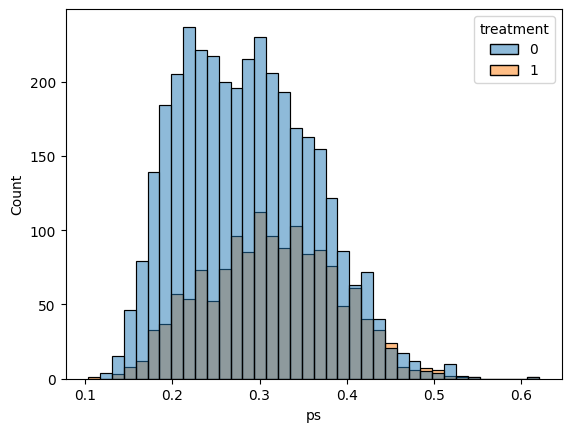

In [18]:
# if not much overlap, the matching won't work
sns.histplot(data=df, x='ps', hue='treatment')  

In [19]:
print(df["ps"].describe(percentiles=[.01,.05,.5,.95,.99]))

count    5000.000000
mean        0.294071
std         0.076679
min         0.103467
1%          0.153584
5%          0.178639
50%         0.292521
95%         0.424481
99%         0.476477
max         0.620760
Name: ps, dtype: float64


There are two popular approaches for propensity score matching: nearest neighbor or caliper matching

nearest neighbor:
- The "nearest neighbor" is always there, even if it is not very similar.
- Plus: it's simple, there's always a couple.
- Minus: you can get "bad" pairs if there are no similar PS in the control group. This adds bias.

caliper matching:
- A pair is selected only if the difference is less than this threshold.
- Caliper = 0.2 × SD logits from PS is usually recommended (Rosenbaum & Rubin rule).
- Plus: protects against "bad" matches → less bias.
- Minus: not all treated will find a match → the sample size decreases (the variance may increase)

In [20]:
caliper = 0.20 * df['ps_logit'].std()
print(f'caliper (logit scale) = {caliper:.4f}')

treated = df[df['treatment']==1].copy()
control = df[df['treatment']==0].copy()

matched_pairs = []
for reg, t_grp in treated.groupby('region'):
    c_grp = control[control['region']==reg].copy()
    if c_grp.empty:
        continue

    # train KNN on control, we look for a neighbor for each treated
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto')
    nbrs.fit(c_grp[['ps_logit']].values)

    dist, idx = nbrs.kneighbors(t_grp[['ps_logit']].values, return_distance=True)

    # use caliper and assemble pairs 1:1 without replacement
    used = set()
    for (t_idx, d, i_ctrl) in zip(t_grp.index, dist.ravel(), idx.ravel()):
        if d <= caliper:
            ctrl_idx = c_grp.iloc[i_ctrl].name
            if ctrl_idx not in used:
                matched_pairs.append((t_idx, ctrl_idx))
                used.add(ctrl_idx)

# forming matched dataset
t_idx = [t for t, _ in matched_pairs]
c_idx = [c for _, c in matched_pairs]

df_matched_treatment = df.loc[t_idx].copy()
df_matched_control   = df.loc[c_idx].copy()

df_matched_treatment['match_id'] = range(len(t_idx))
df_matched_control['match_id']   = range(len(c_idx))

df_matched = pd.concat([df_matched_treatment, df_matched_control], ignore_index=True)

print('Matched counts:', df_matched['treatment'].value_counts().to_dict())

caliper (logit scale) = 0.0758
Matched counts: {1: 1090, 0: 1090}


In [21]:
# student's t-test after matching
_, p = ttest_ind(df_matched_control.post_spend_3m, df_matched_treatment.post_spend_3m)
print(f'p={p:.3f}')

if p > 0.05:
      print('do not have enough evidence to reject H0 -> there is not difference ')
else:
    print('reject H0 - there is difference ')

p=0.000
reject H0 - there is difference 


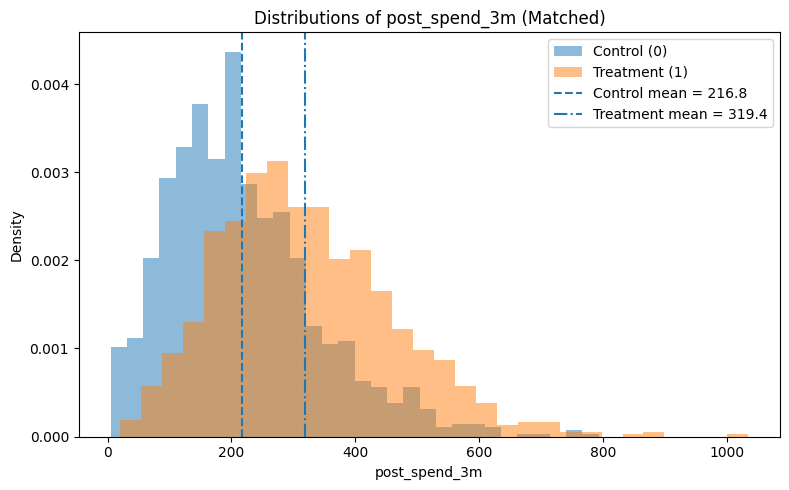

In [22]:
y_c = df_matched_control['post_spend_3m'].values
y_t = df_matched_treatment['post_spend_3m'].values

plt.figure(figsize=(8,5))
plt.hist(y_c, bins=30, density=True, alpha=0.5, label='Control (0)')
plt.hist(y_t, bins=30, density=True, alpha=0.5, label='Treatment (1)')

plt.axvline(y_c.mean(), linestyle='--', linewidth=1.5, label=f'Control mean = {y_c.mean():.1f}')
plt.axvline(y_t.mean(), linestyle='-.', linewidth=1.5, label=f'Treatment mean = {y_t.mean():.1f}')

plt.xlabel('post_spend_3m')
plt.ylabel('Density')
plt.title('Distributions of post_spend_3m (Matched)')
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
_, p = ttest_ind(df_matched_control.income, df_matched_treatment.income)
print(f'p={p:.3f}')

if p > 0.05:
      print('do not have enough evidence to reject H0 -> there is not difference ')
else:
    print('reject H0 - there is difference')

p=0.649
do not have enough evidence to reject H0 -> there is not difference 


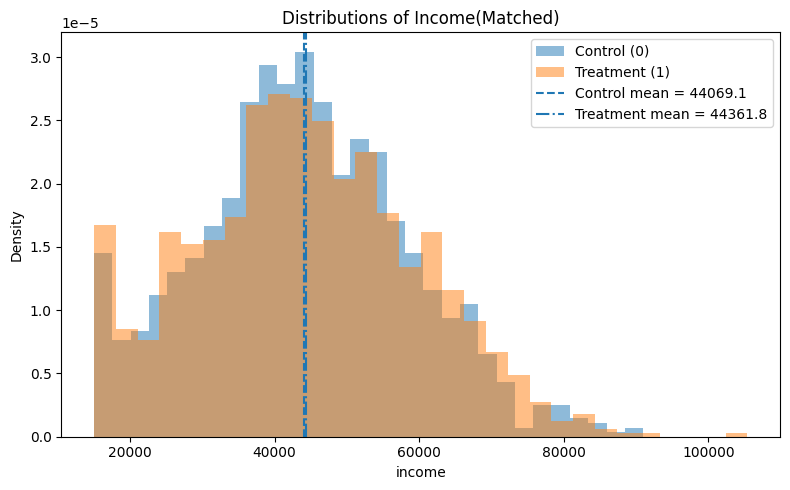

In [24]:
y_c = df_matched_control['income'].values
y_t = df_matched_treatment['income'].values


plt.figure(figsize=(8,5))
plt.hist(y_c, bins=30, density=True, alpha=0.5, label='Control (0)')
plt.hist(y_t, bins=30, density=True, alpha=0.5, label='Treatment (1)')

plt.axvline(y_c.mean(), linestyle='--', linewidth=1.5, label=f'Control mean = {y_c.mean():.1f}')
plt.axvline(y_t.mean(), linestyle='-.', linewidth=1.5, label=f'Treatment mean = {y_t.mean():.1f}')

plt.xlabel('income')
plt.ylabel('Density')
plt.title('Distributions of Income(Matched)')
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
#cohen_d is the standardized mean difference between two independent groups. It shows how many standard deviations the averages differ by.

def cohen_d(a, b):
    n1, n2 = len(a), len(b)
    s1, s2 = np.var(a, ddof=1), np.var(b, ddof=1)
    s = np.sqrt(((n1-1)*s1 + (n2-1)*s2) / (n1+n2-2)) if (n1+n2-2)>0 else 1.0
    return (np.mean(a) - np.mean(b)) / s if s>0 else 0.0

effect_rows = []
cols_check = ['age','income','tenure_months','web_user','freq_last_3m','avg_ticket','prior_spend_3m']

df_ctl = df[df.treatment==0]
df_trt = df[df.treatment==1]
dfm_ctl = df_matched[df_matched.treatment==0]
dfm_trt = df_matched[df_matched.treatment==1]

for cl in cols_check:
    d_before = cohen_d(df_trt[cl].values, df_ctl[cl].values)
    d_after  = cohen_d(dfm_trt[cl].values, dfm_ctl[cl].values)
    effect_rows.append([cl, 'before', d_before])
    effect_rows.append([cl, 'after',  d_after])

df_effect = pd.DataFrame(effect_rows, columns=['feature','matching','effect_size']).sort_values(['feature','matching'])
df_wide = df_effect.pivot(index='feature', columns='matching', values='effect_size').reset_index()
df_wide

matching,feature,after,before
0,age,0.002124,-0.045912
1,avg_ticket,-0.002750,0.092582
2,freq_last_3m,0.038571,0.227717
3,income,0.019497,0.000531
4,prior_spend_3m,0.023889,0.215138
5,tenure_months,-0.003524,0.051530
6,web_user,-0.030812,0.268588


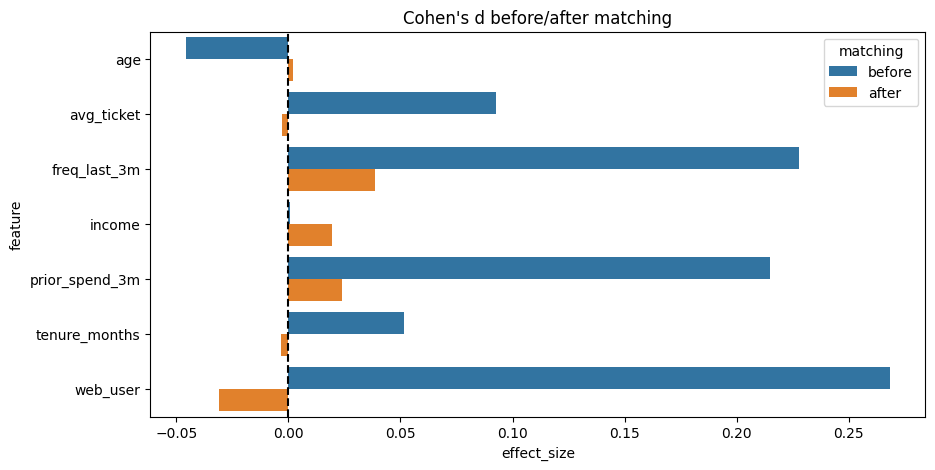

In [26]:
df_melted = df_wide.melt(id_vars='feature', value_vars=['before','after'],
                         var_name='matching', value_name='effect_size')
plt.figure(figsize=(10,5))
sns.barplot(data=df_melted, x='effect_size', y='feature', hue='matching', orient='h')
plt.axvline(0, color='black', linestyle='--')
plt.title("Cohen's d before/after matching")
plt.show()

The matching worked well: the imbalance in all key features decreased significantly

In [27]:
def ate_and_ci(y_treat, y_control, n_boot=1000, ci=95, random_state=42):
    rng = np.random.RandomState(random_state)
    obs_diff = y_treat.mean() - y_control.mean()
    diffs = []
    for _ in range(n_boot):
        s_t = rng.choice(y_treat, size=len(y_treat), replace=True)
        s_c = rng.choice(y_control, size=len(y_control), replace=True)
        diffs.append(s_t.mean() - s_c.mean())
    low = np.percentile(diffs, (100-ci)/2)
    high = np.percentile(diffs, 100-(100-ci)/2)
    return obs_diff, (low, high)


# ATE before matching
y_c0 = df[df.treatment==0]['post_spend_3m'].values
y_t1 = df[df.treatment==1]['post_spend_3m'].values
ate_before, ci_before = ate_and_ci(y_t1, y_c0)

print(f"ATE before matching (naive approach): {ate_before:.2f}, CI={ci_before}")

ATE before matching (naive approach): 125.98, CI=(117.56156667292981, 134.12866547378158)


In [28]:
# ATT after matching
y_c0m = df_matched_control['post_spend_3m'].values
y_t1m = df_matched_treatment['post_spend_3m'].values
ate_after, ci_after = ate_and_ci(y_t1m, y_c0m)

print(f"ATT after matching: {ate_after:.2f}, CI={ci_after}")

ATT after matching: 102.57, CI=(91.17241077981652, 114.08932178899077)


In order not to increase the sample and thus increase the error of the first kind, we will use a stabilized IPTW. In numerators, instead of 1, the probability of treatment received

In [29]:
def stab_iptw_weights(ps, t, stabilize=True, clip=(0.01, 0.99)):
    # cutting off the edge values
    ps = np.clip(ps, clip[0],clip[1])
    p_t = t.mean()
    num = np.where(t==1, p_t, 1-p_t)
    den = np.where(t==1, ps, 1-ps)
    return num/den

def weighted_mean(x,w):
    return np.sum(x*w)/np.sum(w)

def weighted_var(x,w):
    mu = weighted_mean(x,w)
    return np.sum(w*(x-mu)**2)/(np.sum(w)-1)


def smd_numeric_weighted(x, t, w):
    x0, w0 = x[t==0], w[t==0]
    x1, w1 = x[t==1], w[t==1]
    mu0, mu1 = weighted_mean(x0, w0), weighted_mean(x1, w1)
    s0, s1 = weighted_var(x0, w0), weighted_var(x1, w1)
    s = np.sqrt((s0+s1)/2) if s0+s1>0 else 1.0
    return (mu1-mu0)/s

def smd_binary_weighted(x, t, w):
    x0, w0 = x[t==0], w[t==0]
    x1, w1 = x[t==1], w[t==1]
    p0, p1 = weighted_mean(x0, w0), weighted_mean(x1, w1) 
    denom = np.sqrt((p1*(1-p1) + p0*(1-p0)) / 2)
    return (p1 - p0) / denom if denom>0 else 0.0

In [30]:
w = stab_iptw_weights(df_designed["ps"].values, t = df_designed['treatment'].astype(int).values, clip=(0.01, 0.99))
df["w"] = w

In [31]:
for col in ["age","income","tenure_months","freq_last_3m","avg_ticket","prior_spend_3m"]:
    d = smd_numeric_weighted(df[col].values, df['treatment'].values, df['w'].values)
    print(col, d)

for col in ["web_user"]:
    d = smd_binary_weighted(df[col].values, df['treatment'].values, df['w'].values)
    print(col, d)

age -0.003618775557729865
income 0.006802764772631575
tenure_months 0.0049608257760008845
freq_last_3m 0.006128574683955035
avg_ticket -0.0041597994057819615
prior_spend_3m 0.00249654820651096
web_user 0.002106851422126051


the SMD balance after IPTW is excellent


Effective Sample Size (ESS) — shows you how many "real observations" your weighted sample has turned into or a measure of how "informative" your sample is after applying the weights.

In [32]:
ess = (df['w'].sum()**2) / ((df['w']**2).sum())
print("Effective sample size:", ess)

Effective sample size: 4850.385181547879


ESS of ≈ 4850 for initial ~5000 observations means that the weights are stable, there is almost no loss of information, and the ATE estimate is reliable.

In [33]:
def iptw_ate_point(x, t, w):
    w1, w0 = w*(t==1), w*(t==0)
    mu1 = np.sum(w1 * x) / np.sum(w1)
    mu0 = np.sum(w0 * x) / np.sum(w0)
    return mu1 - mu0

def iptw_ci_bootstrap(x, t, ps, n_boot=1000, ci=95, clip=(0.01,0.99)):
    rng = np.random.RandomState(42)
    n = len(x)
    stats = []
    for _ in range(n_boot):
        idx = rng.choice(n, size=n, replace=True)
        x_b, t_b, ps_b = x[idx], t[idx], ps[idx]
        ps_b = np.clip(ps_b, clip[0], clip[1])
        p_t = t_b.mean()
        num = np.where(t_b==1, p_t, 1-p_t)
        den = np.where(t_b==1, ps_b, 1-ps_b)
        w_b = num / den
        stats.append(iptw_ate_point(x_b, t_b, w_b))
    lo = np.percentile(stats, (100-ci)/2)
    hi = np.percentile(stats, 100-(100-ci)/2)
    return lo, hi

In [34]:
x  = df['post_spend_3m'].values.astype(float)
t  = df['treatment'].values.astype(int)
ps = df['ps'].values.astype(float)
w  = df['w'].values.astype(float)

ate_point = iptw_ate_point(x, t, w)
ci_lo, ci_hi = iptw_ci_bootstrap(x, t, ps, n_boot=1000, ci=95)

print(f"IPTW ATE after matching: {ate_point:.2f}, CI= ({ci_lo:.3f}, {ci_hi:.3f})")

IPTW ATE after matching: 98.40, CI= (90.014, 106.223)


# DoWhy Framework

In [35]:
df_designed = pd.DataFrame(X_prepared, columns=feature_names, index=X.index)
df_designed["treatment"] = y.reindex(df_designed.index).to_numpy()

df_designed.head()

,age,income,tenure_months,freq_last_3m,avg_ticket,prior_spend_3m,region_East,region_North,region_South,region_West,web_user_0,web_user_1,treatment
0,-0.537187,0.003529,1.442731,-0.796599,-0.172493,-0.711296,0.0,0.0,0.0,1.0,1.0,0.0,1
1,-0.963738,-1.213789,0.857718,0.398061,-2.064952,-1.066098,0.0,0.0,1.0,0.0,0.0,1.0,0
2,0.072173,-0.152801,0.223953,0.796281,-0.994328,-0.092672,0.0,0.0,0.0,1.0,0.0,1.0,1
3,0.559660,-0.931405,0.418957,-1.593039,-1.606350,-1.484048,1.0,0.0,0.0,0.0,0.0,1.0,0
4,-0.841866,-0.261987,-0.312309,-0.000159,-1.816992,-1.068133,0.0,1.0,0.0,0.0,1.0,0.0,0


In [36]:
X_df = pd.DataFrame(X_prepared, columns=feature_names, index=X.index)
y_series = pd.Series(y, index=X.index, name="treatment").astype(int)
outcome = df.loc[X.index, "post_spend_3m"].rename("post_spend_3m")
df_final= pd.concat([y_series, outcome, X_df], axis=1)

In [37]:
df_final.head()

,treatment,post_spend_3m,age,income,tenure_months,freq_last_3m,avg_ticket,prior_spend_3m,region_East,region_North,region_South,region_West,web_user_0,web_user_1
0,1,204.73,-0.537187,0.003529,1.442731,-0.796599,-0.172493,-0.711296,0.0,0.0,0.0,1.0,1.0,0.0
1,0,74.52,-0.963738,-1.213789,0.857718,0.398061,-2.064952,-1.066098,0.0,0.0,1.0,0.0,0.0,1.0
2,1,224.53,0.072173,-0.152801,0.223953,0.796281,-0.994328,-0.092672,0.0,0.0,0.0,1.0,0.0,1.0
3,0,70.07,0.559660,-0.931405,0.418957,-1.593039,-1.606350,-1.484048,1.0,0.0,0.0,0.0,0.0,1.0
4,0,75.16,-0.841866,-0.261987,-0.312309,-0.000159,-1.816992,-1.068133,0.0,1.0,0.0,0.0,1.0,0.0


In [39]:
model=CausalModel(
        data = df_final,
        treatment= "treatment",
        outcome= "post_spend_3m",
        common_causes=feature_names,
        )

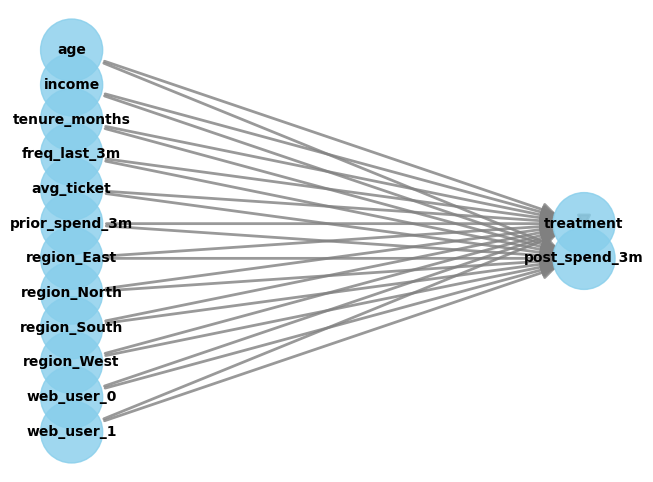

In [40]:
model.view_model()

In [41]:
identified_estimand_experiment = model.identify_effect(proceed_when_unidentifiable=True)

print(model.estimate_effect(identified_estimand_experiment,
    method_name="backdoor.propensity_score_matching",
    method_params={"target_units": "att"},
    confidence_intervals=True))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                         ↪
────────────(E[post_spend_3m|prior_spend_⟨3m,⟩_ticket,web_user_0,freq_last_3m, ↪
d[treatment]                                                                   ↪

↪                                                                              ↪
↪ region_South,income,region_East,region_West,web_user_1,region_North,tenure_m ↪
↪                                                                              ↪

↪            
↪ onths,age])
↪            
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→post_spend_3m then P(post_spend_3m|treatment,prior_spend_3m,avg_ticket,web_user_0,freq_last_3m,region_South,income,region_East,region_West,web_user_1,region_North,tenure_months,age,U) = P(post_spend_3m|treatment,prior_spend_3m,avg_ticket,web_user_0,

In [42]:
print(model.estimate_effect(identified_estimand_experiment,
    method_name="backdoor.propensity_score_weighting",
    method_params={"target_units": "ate"},
    confidence_intervals=True))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                         ↪
────────────(E[post_spend_3m|prior_spend_⟨3m,⟩_ticket,web_user_0,freq_last_3m, ↪
d[treatment]                                                                   ↪

↪                                                                              ↪
↪ region_South,income,region_East,region_West,web_user_1,region_North,tenure_m ↪
↪                                                                              ↪

↪            
↪ onths,age])
↪            
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→post_spend_3m then P(post_spend_3m|treatment,prior_spend_3m,avg_ticket,web_user_0,freq_last_3m,region_South,income,region_East,region_West,web_user_1,region_North,tenure_months,age,U) = P(post_spend_3m|treatment,prior_spend_3m,avg_ticket,web_user_0,

--- 
# Resume

- If the purpose of the analysis is to understand the effect on those who actually participated → take the ATT:
    - manual approach with Propensity Score: 102.57, CI=(91.172, 114.089)
    - DoWhy: 99.46 (92.506, 106.730)

*They match, and the confidence intervals are almost identical. This means that the effect on those who are actually treated is stable and confidently assessed*

- If the purpose of the analysis is to predict the effect of scaling at all → take ATE:
    - naive approach (before matching): 125.98, CI=(117.561, 134.128)
    - manual approach with Propensity Score + IPTW: 98.40, CI=(90.014, 106.223)
    - DoWhy: 98.40 (89.325, 107.265)

*The match is also very close, and the confidence intervals are accurate. You can already see here: the "honest" ATE score after balancing is ~100, and the naive one was clearly overestimated*


To sum up:

- ATT ≈ 100 → the program really increased the expenses of those who joined
- ATE ≈ 98 (not 126) → the effect on all clients is similar, but less than the naive estimate
- Naive → overestimation of the effect ≈ +29%.

## References 
--- 
1. https://www.youtube.com/watch?v=dm-BWjyYQpw
2. https://harrywang.me/psm-did
3. https://towardsdatascience.com/a-hands-on-introduction-to-propensity-score-use-for-beginners-856302b632ac/
4. https://medium.com/data-science/understanding-inverse-probability-of-treatment-weighting-iptw-in-causal-inference-4e69692bce7e